In [ ]:
# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)

In [1]:
import keras
from config_reader import config_reader
import scipy
import math
from keras_definitions import *
from keras.models import model_from_json

weights_path = "model.h5" # orginal weights converted from caffe
#weights_path = "training/weights.best.h5" # weights tarined from scratch 

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

model.load_weights(weights_path)


Using TensorFlow backend.


In [2]:
from config_reader import config_reader
import scipy
import math
import cv2
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import util
%matplotlib inline

In [3]:
# TO DO replace with GetFrame()
test_image = 'test.jpeg'
oriImg = cv2.imread(test_image) # B,G,R order

In [4]:
oriImg.dtype

dtype('uint8')

In [5]:
oriImg.shape

(1280, 960, 3)

In [6]:
# PARA Mandarla via POST
_, img_encoded = cv2.imencode('.jpeg', oriImg)

In [7]:
encoded = img_encoded.tostring()

In [8]:
nparr = np.frombuffer(encoded, np.uint8)

In [9]:
oriImg = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

In [10]:
oriImg.shape

(1280, 960, 3)

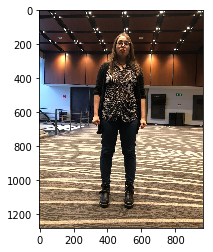

In [11]:

plt.imshow(oriImg[:,:,[2,1,0]]);

In [12]:
param, model_params = config_reader()
multiplier = [x * model_params['boxsize'] / oriImg.shape[0] for x in param['scale_search']][3]

In [13]:
scale = multiplier

In [14]:
heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 19))
#paf_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 38))

imageToTest = cv2.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
imageToTest_padded, pad = util.padRightDownCorner(imageToTest, model_params['stride'], model_params['padValue'])        
    
input_img = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,0,1,2)) # required shape (1, width, height, channels) 
print("Input shape: " + str(input_img.shape))  


Input shape: (1, 736, 552, 3)


In [15]:
%%timeit
output_blobs = model.predict(input_img)

1 loop, best of 3: 1.59 s per loop


In [ ]:
print("Output shape (heatmap): " + str(output_blobs[1].shape))

In [ ]:

    
# extract outputs, resize, and remove padding
heatmap = np.squeeze(output_blobs[1]) # output 1 is heatmaps
heatmap = cv2.resize(heatmap, (0,0), fx=model_params['stride'], fy=model_params['stride'], interpolation=cv2.INTER_CUBIC)
heatmap = heatmap[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
    
# paf = np.squeeze(output_blobs[0]) # output 0 is PAFs
# paf = cv2.resize(paf, (0,0), fx=model_params['stride'], fy=model_params['stride'], interpolation=cv2.INTER_CUBIC)
# paf = paf[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
# paf = cv2.resize(paf, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

heatmap_avg = heatmap_avg + heatmap / 1
# paf_avg = paf_avg + paf / len(multiplier)

In [ ]:
input_img

In [ ]:
from scipy.ndimage.filters import gaussian_filter
all_peaks = []
peak_counter = 0

for part in range(19-1):
    map_ori = heatmap_avg[:,:,part]
    map = gaussian_filter(map_ori, sigma=3)
    
    map_left = np.zeros(map.shape)
    map_left[1:,:] = map[:-1,:]
    map_right = np.zeros(map.shape)
    map_right[:-1,:] = map[1:,:]
    map_up = np.zeros(map.shape)
    map_up[:,1:] = map[:,:-1]
    map_down = np.zeros(map.shape)
    map_down[:,:-1] = map[:,1:]
    
    peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up, map>=map_down, map > param['thre1']))
    peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0])) # note reverse
    peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
    id = range(peak_counter, peak_counter + len(peaks))
    peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

    all_peaks.append(peaks_with_score_and_id)
    peak_counter += len(peaks)

In [ ]:
all_peaks

In [ ]:
# visualize
colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
cmap = matplotlib.cm.get_cmap('hsv')

canvas = cv2.imread(test_image) # B,G,R order


for i in range(1):
    i = 3
    rgba = np.array(cmap(1 - i/18. - 1./36))
    rgba[0:3] *= 255
    for j in range(len(all_peaks[i])):
        cv2.circle(canvas, all_peaks[i][j][0:2], 4, colors[i], thickness=-1)

to_plot = cv2.addWeighted(oriImg, 0.3, canvas, 0.7, 0)
plt.imshow(to_plot[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)